#  Monte-Carlo fit to a Gaussian distribution


### This was an attempt to fit using MC. 
Problems encountered:
- Exponential of a large number results in issues with sampling
- Need to write different updates for each function.


### Decided to stall this for now(as on Aug 16,2017). Will try the python package 'emcee' instead.

## Index:
* [Set-up](#setup)
* [Exact](#exact)
* [Metropolis](#metropolis)
* [numpy](#numpy)
* [Comparison](#comparison)
     

In [1]:

import numpy as np
import scipy as sp
import pandas as pd
import itertools


# Graphics
%matplotlib notebook
import matplotlib.pyplot as plt
# plt.style.use('ggplot')


import lsqfit
import gvar as gv

# Code for neat formatting.
from IPython.display import display, HTML, Markdown
def printmd(string):
    display(Markdown(string))




<a id = 'setup'></a>
### Parameters $ \mu$ , $\sigma$ and function

In [2]:
def f_choose_func(ftno=1):
    if ftno==1:
        def f_gauss(x,mu,sigma):
            ''' Normal distribution'''
            return (1.0/(np.sqrt(2*np.pi)*sigma))*np.exp(-((x-mu)**2)/(2.0*sigma**2))
        return f_gauss

f_func=f_choose_func(1)


In [3]:
# ? f_func

## Chi-square distribution:

$$ \chi^2 = \sum_{i=1}^n \left({\frac{{O_i-E_i}}{\sigma_i}}\right)^2$$


$$ f(\chi^2)= \frac{1}{2^{\nu / 2} \Gamma(\nu / 2)} e^{-\frac{\chi^2}{2} } {\left(\chi^2\right)}^{\nu /2 -1 } $$

In [4]:
def f_chi_sqr(xarr,yarr,yerr,param):
    '''
    Reads 'xarr', 'yarr' and dictionary of parameters-> 'param'
    '''
    y_exp=f_func(xarr,**param)
    chi_sqr= np.sum(((yarr-y_exp)/(yerr))**2)
    print param['mu'],param['sigma']
    return np.exp(-1.0*chi_sqr)
#     return np.exp(-1.0*chi_sqr)*chi_sqr


<a id = 'exact'></a>

## Creating a sample using the exact formula:


In [5]:
mu,sigma=0,1.1


[  2.05350773e-07   2.77886262e-05   1.35558075e-03   2.38380810e-02
   1.51114024e-01   3.45323257e-01   2.84468688e-01   8.44754844e-02
   9.04304086e-03   3.48968218e-04] [  2.04516166e-07   2.76073501e-05   1.35809889e-03   2.39395118e-02
   1.49664804e-01   3.45597519e-01   2.83230452e-01   8.53558547e-02
   9.05510288e-03   3.45808926e-04]


<IPython.core.display.Javascript object>


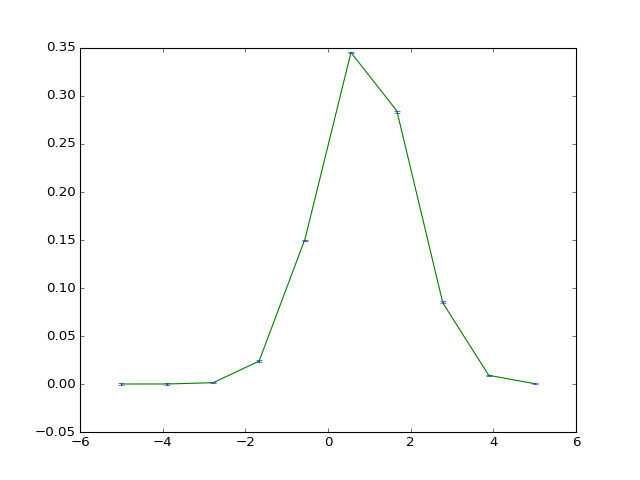

In [14]:
# Create data


xdata=np.linspace(-5,5,10)
param={'mu':mu,'sigma':sigma}

yexp=f_func(xdata,**param)

ydata=yexp+yexp*np.random.normal(0,0.005,len(xdata))
yerr=np.random.normal(0,0.001)*np.ones(len(xdata))

# print xdata,ydata,yerr

print yexp,ydata

plt.figure()
plt.errorbar(xdata,ydata,yerr,linestyle='')
plt.plot(xdata,yexp)

In [ ]:
for i in range(len(xdata)):
    print ydata[i],yexp[i],yerr[i],((ydata[i]-yexp[i])/(yerr[i]))**2
    
    
print np.sum(((ydata-yexp)/yerr)**2)

In [15]:
def f_chi_sqr(xarr,yarr,yerr,param):
    '''
    Reads 'xarr', 'yarr' and dictionary of parameters-> 'param'
    '''
    y_exp=f_func(xarr,**param)
    chi_sqr= np.sum(((yarr-y_exp)/(yerr))**2)
#     chi_sqr= ((yarr-y_exp)/(yerr))**2
    
#     print y_exp
    dof= len(xarr)-len(param)
    assert dof>0,"Too few degrees of freedom"
    
    pdf=(2**(dof/2.0))
    print chi_sqr,
#     return chi_sqr
    print np.exp(-1.0*chi_sqr/2.0)*chi_sqr**(dof/2.0-1.0)
#     return np.exp(-1.0*chi_sqr/2.0)*chi_sqr**(dof/2.0-1.0)
#     print param['mu'],param['sigma']
#     return np.exp(-1.0*chi_sqr)
#     return np.exp(-1.0*chi_sqr)*chi_sqr



for mu in np.arange(0.0,1,0.1):
    print mu,
    param['mu']=mu
    f_chi_sqr(xdata,ydata,yerr,param)
    
# print ((ydata-yexp)/yerr)**2
# print yexp,'\n',f_func(xdata,**param)

0.0 172082.368353 0.0
0.1 138321.694425 0.0
0.2 107549.874494 0.0
0.3 80111.7374955 0.0
0.4 56316.6124614 0.0
0.5 36435.709872 0.0
0.6 20700.0122907 0.0
0.7 9297.7489141 0.0
0.8 2370.9114894 0.0
0.9 10.8551074656 5.62012203092


In [ ]:
param

## General idea :
- Start with a parameter guess.
- Propose a new point in parameter space.
- Compute chi-square distribution weight.
- Use Metropolis to accep/reject this new point.
- Repeat the procedure to obtain a list of parameters.
- Statistics on this gives you estimate of the minimum with errors. This is the fit value and error.


<a id = 'metropolis'></a>

## Sampling using Metropolis Algorithm

In [ ]:
num_mc=100 # number of MC updates.


# Dictionary with numpy array for each parameter. Stores MC points.
param_mc=dict.fromkeys(param.keys(),np.zeros(num_mc))
# Arrays to store acpt/reject, weight of the new conf calculate.
acpt_arr=np.ones(num_mc,dtype=np.int)*-2
wght=np.zeros(num_mc)

# Choosing a seed for reproducibility.
np.random.seed(10207)

# head is the starting point in the real plane. We pick it to be a random number in the range -5,5
mx,mn=5,-5
head=mn+np.random.random()*(mx-mn)

# jump_size is the distance of the new point chosen (tail) from the old one (head)
jump_size=sigma/2.0

print head,jump_size

### Update.
- You have 2 parameters mu and sigma
- Find a way to update both.
- Start off with random moves.

### Project stalled!